<a href="https://colab.research.google.com/github/btran30/cs584/blob/brenda/Densenet201_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet 201 Analysis

## Library Import

In [9]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from matplotlib import pyplot

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


## Load Data from Keras

In [10]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()

# One-hot encoding for 100 classes.
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

170500096/170498071 [==============================] - 4s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


## DenseNet 201 Model

We utilize ImageDataGenerator to augment our input data.  This should help us avoid overfitting.

In [11]:
input_shape=(32,32,3)
model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=input_shape) 

x=model_d.output

x= BatchNormalization()(x)
x= Activation('relu')(x)
x= GlobalAveragePooling2D()(x)

preds=Dense(100,activation='softmax')(x) #FC-layer

model=Model(inputs=model_d.input, outputs=preds)

#model.summary()
#tf.keras.utils.plot_model( model , show_shapes=True )

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

batch_size = 128
epochs = 20

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(x_train)
# Fits-the-model
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
               steps_per_epoch=x_train.shape[0] // batch_size,
               epochs=epochs,
               verbose=1,
               callbacks=[anne, checkpoint],
               validation_data=(x_test, y_test))

#model.save("m_densenet201.h5")

Epoch 1/20
390/390 [==============================] - ETA: 0s - loss: 1.1578 - accuracy: 0.6014 - top_k_categorical_accuracy: 0.9324
Epoch 00001: val_loss improved from inf to 0.84656, saving model to model.h5
390/390 [==============================] - 52s 134ms/step - loss: 1.1578 - accuracy: 0.6014 - top_k_categorical_accuracy: 0.9324 - val_loss: 0.8466 - val_accuracy: 0.7177 - val_top_k_categorical_accuracy: 0.9758
Epoch 2/20
390/390 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7687 - top_k_categorical_accuracy: 0.9866
Epoch 00002: val_loss improved from 0.84656 to 0.62500, saving model to model.h5
390/390 [==============================] - 49s 127ms/step - loss: 0.6718 - accuracy: 0.7687 - top_k_categorical_accuracy: 0.9866 - val_loss: 0.6250 - val_accuracy: 0.7850 - val_top_k_categorical_accuracy: 0.9871
Epoch 3/20
390/390 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.8147 - top_k_categorical_accuracy: 0.9918
Epoch 00003: val_lo

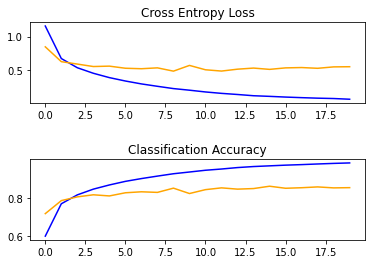

In [23]:
def summarize_diagnostics(history):
    pyplot.subplots_adjust(hspace=0.7)
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    filename = "DenseNet201_Pretrained"
    pyplot.savefig(filename + '_plot.png')
    

summarize_diagnostics(history)

## Final Prediciton

In [24]:
ypred = model.predict(x_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 10000 	accurately-predicted-data: 8520 	 wrongly-predicted-data:  1480
Accuracy: 85.2 %


### Heat Map

In [ ]:
Ypred = model.predict(x_test)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(y_test, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
